In [90]:
import captum.attr as ca, torch, pickle, os
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from torch_geometric.loader import DataLoader
from tqdm import tqdm

In [10]:
path = osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/results_percentile_131121/Sage_vlarge_redshift_0_all_qkktxg_4_10/trained_model/model.pt')

In [14]:
from dev.models import Sage

In [20]:
model = Sage(in_channels=43, out_channels=1, hidden_channels=32, decode_layers=1)

RelU conv activation


In [21]:
# device = torch.device('cpu')
# model.load_state_dict(torch.load(path, map_location=device))
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [22]:
model.eval()

Sage(
  (convs): ModuleList(
    (0): SAGEConv(43, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (decode): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
  (conv_act): ReLU()
)

In [24]:
case='vlarge_redshift_99_all'
data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))

In [155]:
test_data=data[int(len(data)*0.8):]
test_loader=DataLoader(test_data[:10000:100], batch_size=1, shuffle=0,num_workers=1)    

### Shapley Sampling (https://captum.ai/api/shapley_value_sampling.html)

In [156]:
svs = ca.ShapleyValueSampling(model)
# svs = ca.ShapleyValues(model)

In [157]:
attr=[]
ys=[]
j=0
for dat in tqdm((test_loader)):
    if j==0:
        case1=(dat.x,dat.edge_index, dat.batch)
    attr.append(svs.attribute((dat.x,dat.edge_index, dat.batch), baselines=case1)[0].numpy())
    ys.append(dat.y.numpy())
    j+=1

100%|█████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


In [158]:
attr

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[ 1.77016303e-01, -1.01831007e+00, -3.26773256e-01,
          1.00340597e-01,  5.90980388e-02,  1.51456684e-01,
          2.97040761e-01,  0.00000000e+00, -3.62014808e-02,
          3.86847198e-01,  1.23977657e-06,  8.82148754e-08,
         -1.64508819e-07, -1.25935080e-03,  7.05501065e-03,
          1.84876917e-04, -8.65865499e-03,  3.55955549e-02,
          3.22269350e-02, -4.14568174e-04, -2.29440108e-02,
          7.84153491e-02,  1.26334727e-01,  2.71219518e-02,
          2.72286758e-02,  1.97960474e-02,  6.13431912e-04,
          2.27571111e-02, -3.50527093e-02,  1.19077303e-02,
         -2.34312657e-03, -2.22663512e-03, -1.06862495e-02,
          4.79251184e-02,  1.95323824e-04, -3.26569304e-02,
          2.59819180e-02, -3.91908512e-02,  2.57880203e-02,
   

In [160]:
ys=np.hstack(ys)
attr=np.vstack(attr)

In [161]:
np.mean(ys)

-1.239526

In [162]:
ab=np.sum(np.abs(attr), axis=1)
su=np.sum(attr, axis=1)

Text(0, 0.5, 'abs sum of shap values')

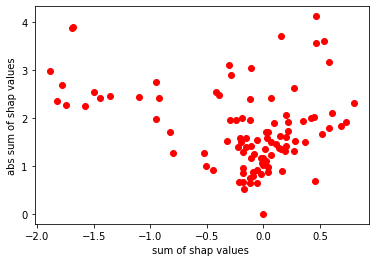

In [163]:
plt.plot(su, ab, 'ro')

plt.xlabel('sum of shap values ')
plt.ylabel('abs sum of shap values')
# plt.title(np.round(np.corrcoef(ys-ab,ys)[0][1],2))

Text(0.5, 1.0, '0.42')

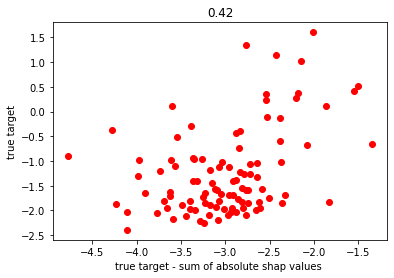

In [164]:
plt.plot(ys-ab, ys, 'ro')

plt.xlabel('true target - sum of absolute shap values ')
plt.ylabel('true target')
plt.title(np.round(np.corrcoef(ys-ab,ys)[0][1],2))

Text(0.5, 1.0, '0.84')

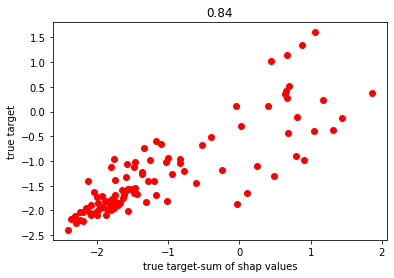

In [165]:
plt.plot(ys-su, ys, 'ro')

plt.xlabel('true target-sum of shap values')
plt.ylabel('true target')
plt.title(np.round(np.corrcoef(ys-su,ys)[0][1],2))

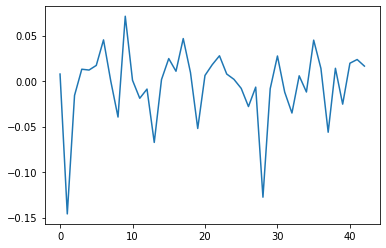

In [173]:
plt.plot(np.mean(np.vstack(attr), axis=0))
# plt.yscale('log')

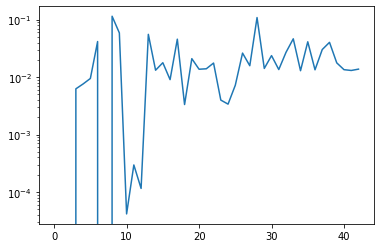

In [167]:
plt.plot(np.median(np.abs(np.vstack(attr)), axis=0))
plt.yscale('log')

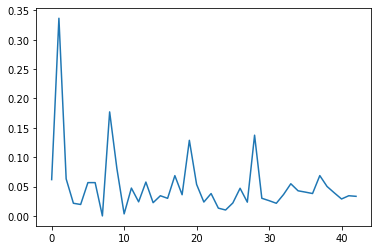

In [170]:
plt.plot(np.std(np.abs(np.vstack(attr)), axis=0))
# plt.yscale('log')


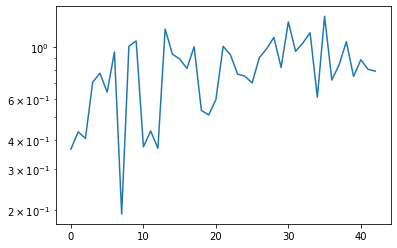

In [169]:
plt.plot(np.mean(np.abs(np.vstack(attr)), axis=0)/np.std(np.abs(np.vstack(attr)), axis=0))
plt.yscale('log')

## DeepLiftShap (https://captum.ai/api/deep_lift_shap.html), has to provide baseline

In [80]:
dl = ca.DeepLift(model)
attr_dl=[]
for dat in test_loader:
    attr_dl.append(dl.attribute((dat.x,dat.edge_index, dat.batch), dat.y)[0].numpy())

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/captum/_utils/gradient.py:48: UserWarning: Input Tensor 1 has a dtype of torch.int64.
                    Gradients cannot be activated
                    for these data types.
  warnings.warn(
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/captum/_utils/gradient.py:48: UserWarning: Input Tensor 2 has a dtype of torch.int64.
                    Gradients cannot be activated
                    for these data types.
  warnings.warn(


AssertionError: Input and baseline must have the same dimensions, baseline has 1 features whereas input has 3.